 An Option Pricing Model based on the framework of Black-Scholes and Monte Carlo model using python. This
 model compares the solutions obtained by both the models and includes risk analysis and volatility prediction of
 europian call option using machine learning.

Text(value='AAPL', description='Ticker:', style=DescriptionStyle(description_width='initial'))

DatePicker(value=datetime.datetime(2020, 1, 1, 0, 0), description='Start Date:')

DatePicker(value=datetime.datetime(2023, 1, 1, 0, 0), description='End Date:')

FloatText(value=150.0, description='Strike Price:')

FloatText(value=0.05, description='Risk-Free Rate:')

FloatText(value=0.2, description='Volatility:')

FloatText(value=1.0, description='Time to Maturity (Years):')

Button(description='Calculate Option Pricing & Greeks', style=ButtonStyle())

[*********************100%***********************]  1 of 1 completed


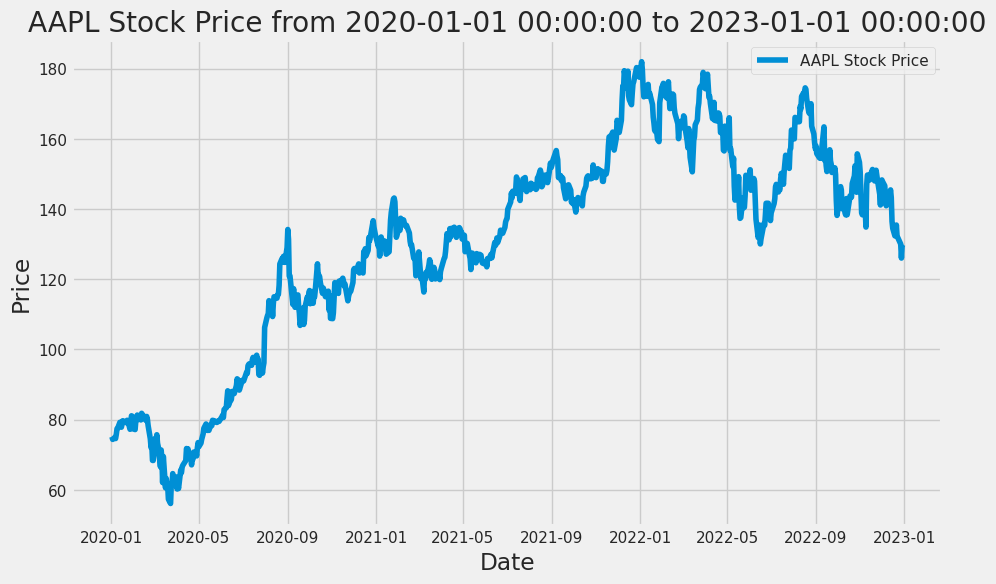

<ipython-input-1-6dfeb76598a5>:124: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])  # Ensure it's a float



European Call Option Price: $5.64
Option Greeks: {'Delta': 0.3563629749069537, 'Gamma': 0.014346043057874699, 'Theta': -6.8766406571773375, 'Vega': 48.437414537125235, 'Rho': 40.65798406929626}


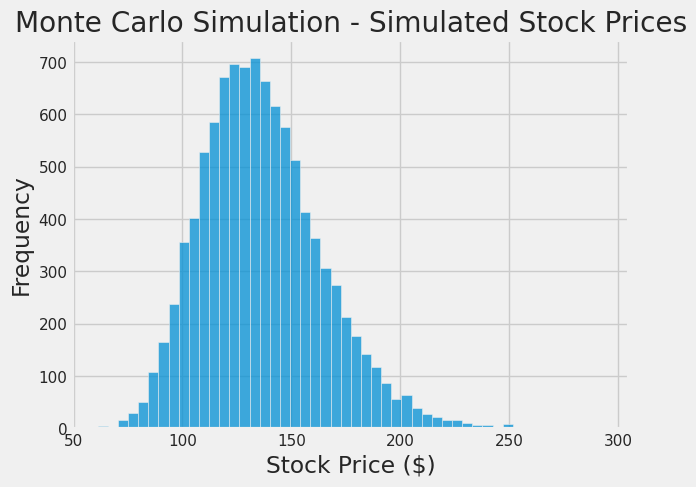

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf  # For fetching market data
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets

sns.set()
plt.style.use('fivethirtyeight')


# ------------------ Utility Functions ------------------

def fetch_market_data(ticker, start_date, end_date):
    """
    Fetch historical market data for a given ticker using Yahoo Finance API.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data


def calculate_historical_volatility(data, window=30):
    """
    Calculate historical volatility using rolling window standard deviation.
    """
    log_returns=np.log(data['Close']/data['Close'].shift(1))
    return log_returns.rolling(window).std()*np.sqrt(252)


def monte_carlo_simulation(S,r,sigma,T,num_paths=100000):
    """
    Simulate stock price paths using Monte Carlo.
    """
    np.random.seed(42)
    dt=T/num_paths
    Z=np.random.normal(0,1,num_paths)
    ST=S*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z)
    return ST


# ------------------ Pricing Models ------------------

def black_scholes_call(S,X,r,sigma,T):
    """
    Black-Scholes model for European call option pricing.
    """
    d1=(np.log(S/X)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return S*norm.cdf(d1)-X*np.exp(-r*T)*norm.cdf(d2)


def american_option_pricing(S,X,r,sigma,T,option_type='call',num_steps=100):
    """
    Binomial model for American option pricing.
    """
    dt=T/num_steps
    u=np.exp(sigma*np.sqrt(dt))
    d=1/u
    p=(np.exp(r*dt)-d)/(u-d)
    option_values=np.zeros((num_steps+1,num_steps+1))

    for i in range(num_steps+1):
        ST=S*(u*i)*(d*(num_steps-i))
        option_values[i,num_steps]= max(ST-X,0) if option_type == 'call' else max(X-ST, 0)

    for j in range(num_steps - 1,-1,-1):
        for i in range(j+1):
            option_values[i,j]= np.exp(-r *dt)*(
                p*option_values[i+1,j+1]+(1-p)*option_values[i,j + 1]
            )
            ST =S*(u*i)*(d*(j-i))
            if option_type == 'call':
                option_values[i, j] = max(option_values[i, j], ST - X)
            else:
                option_values[i, j] = max(option_values[i, j], X - ST)

    return option_values[0, 0]


# ------------------ Risk Management ------------------

def calculate_greeks(S, X, r, sigma, T):
    """
    Calculate option Greeks for risk management.
    """
    d1 = (np.log(S/X) + (r+0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1)/(S*sigma*np.sqrt(T))
    theta = -(S *norm.pdf(d1) *sigma)/(2* np.sqrt(T)) - r * X * np.exp(-r * T) * norm.cdf(d2)
    vega = S *norm.pdf(d1)* np.sqrt(T)
    rho = X *T* np.exp(-r * T) *norm.cdf(d2)

    return {'Delta': delta, 'Gamma': gamma, 'Theta': theta, 'Vega': vega, 'Rho': rho}


# ------------------ User Input Interface with ipywidgets ------------------

# Function to calculate and display the option pricing and Greeks based on user input
def option_pricing_dashboard(ticker, start_date, end_date, strike_price, risk_free_rate, volatility, time_to_maturity):
    """
    Option pricing and Greeks calculation based on user input.
    """

    # Fetch market data
    data = fetch_market_data(ticker, start_date, end_date)

    # Plotting the stock price graph
    plt.figure(figsize=(10, 6))
    plt.plot(data['Close'], label=f'{ticker} Stock Price')
    plt.title(f"{ticker} Stock Price from {start_date} to {end_date}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Ensure 'data' is a DataFrame and fetch the last closing price as a float
    current_price = float(data['Close'].iloc[-1])  # Ensure it's a float

    # Calculate the European call option price using Black-Scholes model
    call_price = black_scholes_call(current_price, strike_price, risk_free_rate, volatility, time_to_maturity)
    print(f"\nEuropean Call Option Price: ${call_price:.2f}")

    # Greeks Calculation
    greeks = calculate_greeks(current_price, strike_price, risk_free_rate, volatility, time_to_maturity)
    print("Option Greeks:", greeks)

    # Monte Carlo Simulation (optional)
    num_paths = 10000  # Number of paths for Monte Carlo
    simulated_prices = monte_carlo_simulation(current_price, risk_free_rate, volatility, time_to_maturity, num_paths)

    # Plotting the Monte Carlo Simulation
    plt.hist(simulated_prices, bins=50, alpha=0.75)
    plt.title("Monte Carlo Simulation - Simulated Stock Prices")
    plt.xlabel("Stock Price ($)")
    plt.ylabel("Frequency")
    plt.show()


# ------------------ Widgets for User Input ------------------

# Creating input widgets for user to input the necessary values
ticker_input = widgets.Text(value='AAPL', description='Ticker:', style={'description_width': 'initial'})
start_date_input = widgets.DatePicker(value=datetime(2020, 1, 1), description='Start Date:')
end_date_input = widgets.DatePicker(value=datetime(2023, 1, 1), description='End Date:')
strike_price_input = widgets.FloatText(value=150.0, description='Strike Price:')
risk_free_rate_input = widgets.FloatText(value=0.05, description='Risk-Free Rate:')
volatility_input = widgets.FloatText(value=0.2, description='Volatility:')
time_to_maturity_input = widgets.FloatText(value=1.0, description='Time to Maturity (Years):')

# Button to trigger the calculation
button = widgets.Button(description="Calculate Option Pricing & Greeks")
button.on_click(lambda b: option_pricing_dashboard(ticker_input.value, start_date_input.value,
                                                   end_date_input.value, strike_price_input.value,
                                                   risk_free_rate_input.value, volatility_input.value,
                                                   time_to_maturity_input.value))

# Display the widgets
display(ticker_input, start_date_input, end_date_input, strike_price_input,
        risk_free_rate_input, volatility_input, time_to_maturity_input, button)